In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf


%matplotlib inline


### 准备数据

In [3]:
num_classes = 10
img_rows, img_cols, img_ch = 28, 28, 1
input_shape = (img_rows, img_cols, img_ch)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

print('Training data: {}'.format(x_train.shape))
print('Testing data: {}'.format(x_test.shape))


Training data: (60000, 28, 28, 1)
Testing data: (10000, 28, 28, 1)


### 准备模型


我们重用了之前实现的 _LeNet-5_ 模型。然而，为了使代码更简洁，我们使用`tf.keras.Sequential`构建模型，

从`tf.keras.Model`继承的类。创建顺序体系结构的模型。

我们还将网络的实例化包装成一个函数, 这样我们就可以产生多个:

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D


In [5]:
def lenet(name='lenet'):
    model = Sequential(name=name)
    # 1st block:
    model.add(Conv2D(6, kernel_size=(5, 5), padding='same',
              activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 2nd block:
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dense layers:
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model


## 与各种优化器一起训练


In [6]:
from tensorflow.keras import optimizers

# Setting some variables to format the logs:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\n\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'


为了展示 流行的优化器（TensorFlow和Keras中提供）对训练的影响，
我们将创建几个类似的LeNet实例，并使用不同的优化器对每个实例进行训练。

首先，我们实例化了要比较的各种优化器[$^{3,4,5,6,7,8}$](#ref):


https://tensorflow.google.cn/api_docs/python/tf/keras/optimizers/SGD?hl=zh_cn


```python
tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD', **kwargs
)
```

- learning_rate: 学习率（步长）
- weight_decay:（权重衰退）
- Nesterov Momentum: (牛顿动量)

In [7]:
# 
optimizers_examples = {
    'sgd': optimizers.SGD(),
    'momentum': optimizers.SGD(momentum=0.9),
    'nag': optimizers.SGD(momentum=0.9, nesterov=True),
    'adagrad': optimizers.Adagrad(),
    'adadelta': optimizers.Adadelta(),
    'rmsprop': optimizers.RMSprop(),
    'adam': optimizers.Adam()
}

对于我们正在考虑的每个优化器，我们将实例化一个新的LeNet模型，并使用它进行训练。

我们将保存他们的训练 `历史` (包含培训期间的损失和指标历史记录), 作为比较 *(这个过程需要时间，尤其是在CPU上!)*:

In [8]:
history_per_optimizer = dict()

print("Experiment: {0}start{1} (training logs = off)".format(
    log_begin_red, log_end_format))
for optimizer_name in optimizers_examples:
    # Resetting the seeds (for random number generation), to reduce the impact of randomness on the comparison:
    tf.random.set_seed(42)
    np.random.seed(42)
    # Creating the model:
    model = lenet("lenet_{}".format(optimizer_name))
    optimizer = optimizers_examples[optimizer_name]
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Launching the training (we set `verbose=0`, so the training won't generate any logs):
    print("\t> Training with {0}: {1}start{2}".format(
        optimizer_name, log_begin_red, log_end_format))
    history = model.fit(x_train, y_train,
                        batch_size=32, epochs=20, validation_data=(x_test, y_test),
                        verbose=0)
    history_per_optimizer[optimizer_name] = history
    print('\t> Training with {0}: {1}done{2}.'.format(
        optimizer_name, log_begin_green, log_end_format))
print("Experiment: {0}done{1}".format(log_begin_green, log_end_format))


Experiment: start (training logs = off)
	> Training with sgd: start
	> Training with sgd: done.
	> Training with momentum: start
	> Training with momentum: done.
	> Training with nag: start
	> Training with nag: done.
	> Training with adagrad: start
	> Training with adagrad: done.
	> Training with adadelta: start
	> Training with adadelta: done.
	> Training with rmsprop: start
	> Training with rmsprop: done.
	> Training with adam: start
	> Training with adam: done.
Experiment: done


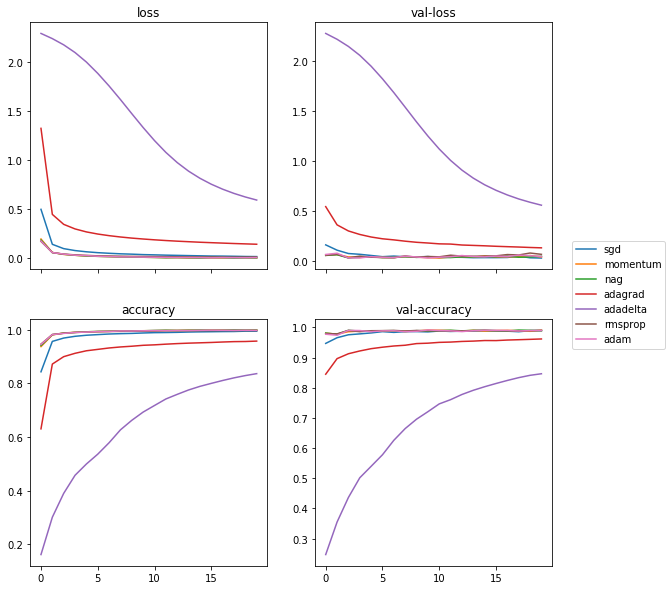

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("accuracy")
ax[1, 1].set_title("val-accuracy")

lines, labels = [], []
for optimizer_name in history_per_optimizer:
    history = history_per_optimizer[optimizer_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['accuracy'])
    line = ax[1, 1].plot(history.history['val_accuracy'])
    lines.append(line[0])
    labels.append(optimizer_name)

fig.legend(lines, labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.85)


# 结论